In [19]:
from research.analysis import nlp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
docs, labels = nlp.load_documents(n=50)

In [21]:
entity_map = nlp.extract_entity_id_map(docs, extractor=nlp._text_to_tokens)

Entity count: 14083


(array([ 819., 4619., 5259., 2293.,  615.,  215.,  107.,   79.,   43.,
          34.]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 10 Patch objects>)

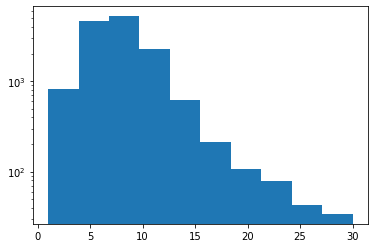

In [22]:
import numpy as np
entity_lengths = [len(e) for e in entity_map.keys()]
print("Entity count: {}".format(len(entity_lengths)))
plt.hist(entity_lengths, log=True)

In [23]:
import random
random.choices(list(entity_map.keys()), k=20)

['counties',
 'manage',
 'bonds',
 'considers',
 'announce',
 'hope',
 'pros',
 'arms',
 'titans',
 'wingra',
 'rehab',
 'thinning',
 'restart',
 'postmates',
 'prioritiesas',
 'mc',
 'rounds',
 'permission',
 'unambiguous',
 'gather']

In [24]:
bag = nlp.bag_of_entities(docs, entity_map)

In [25]:
tfidf = nlp.tfidf(bag)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, labels, test_size=0.5, random_state=40)

In [27]:
len(y_test)

50

In [28]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='BLM')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 10})

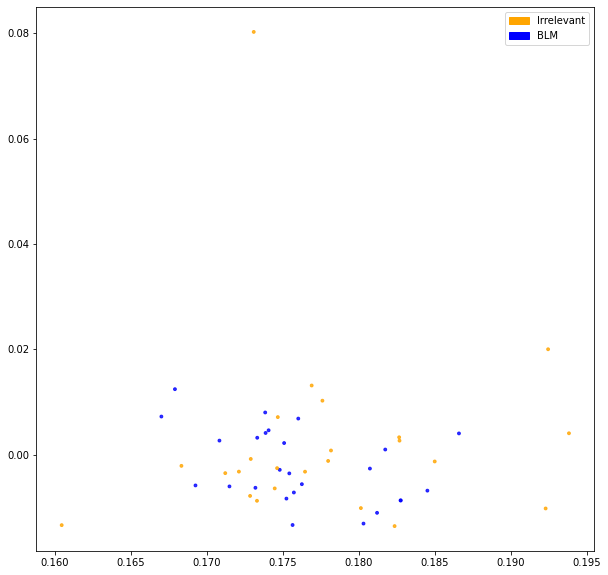

In [29]:
fig = plt.figure(figsize=(10,10))          
plot_LSA(X_train, y_train)
plt.show()

In [30]:

from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1, class_weight='balanced', solver='newton-cg', random_state=41)
clf.fit(X_train, y_train)

y_predicted_counts = clf.predict(X_train)

In [31]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.460, precision = 0.462, recall = 0.460, f1 = 0.459


In [32]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=8)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)

    return plt

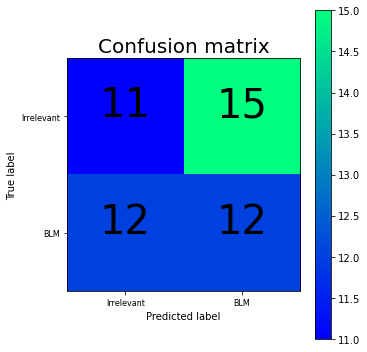

[[11 15]
 [12 12]]


In [33]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(5,5))
plot = plot_confusion_matrix(cm, classes=['Irrelevant','BLM'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [34]:
import json
from research.utils import path
from scipy.sparse import save_npz

base_dir = "research/data/working_set"

with open(pathto(base_dir, "document_list.json"), 'w') as f:
    json.dump(docs, f)

with open(pathto(base_dir, "entity_map.json"),'w') as f:
    json.dump(entity_map, f)

save_npz(pathto(base_dir, "bag_of_words.npz"), bag)
save_npz(pathto(base_dir, "tfidf.npz"), tfidf)

AttributeError: 'str' object has no attribute 'write'

In [35]:
# how many of the 70k words, are not common words (or perhaps within a couple letters of a common word)?

In [36]:
# what are the outlayers in terms of tfidf or bow scores
# - across documents
# - across words